# Import

In [75]:
import pandas as pd
import numpy as np
from datetime import datetime
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import torch
import torch.nn as nn

test_period = [['2023-11-01', '2024-06-01']]
#test_period = [['2022-11-01', '2023-06-01']]

# Read Data

,gas_value,Monthly EV Sales with Noise,Close,stations_number,Number of Licensed Drivers,electricity_price
year-month,,,,,,
2021-01-01,2.42025,845.419355,54.295263,85615.0,2.327820e+08,0.136
2021-02-01,2.58700,982.357143,57.543684,86786.0,2.328538e+08,0.137
2021-03-01,2.89760,1396.096774,55.610435,88122.0,2.329257e+08,0.138
2021-04-01,2.94775,1178.300000,57.717619,89724.0,2.329975e+08,0.139
2021-05-01,3.07620,1000.290323,48.893000,91551.0,2.330693e+08,0.140


<AxesSubplot:xlabel='year-month'>

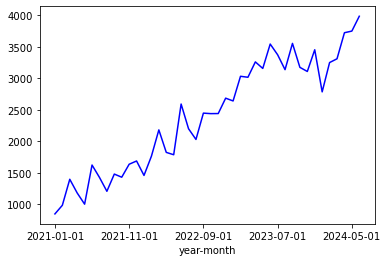

In [76]:
data = pd.read_csv('./updated_merged_df.csv')
data['year-month'] = data['year-month'].apply(lambda x: str(datetime.strptime(x, '%Y-%m'))[:10])
data.set_index(keys=['year-month'], inplace=True)
sub_data = data[data['Monthly EV Sales with Noise'] > 0].copy()
display(sub_data.head(5))
sub_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue')

# Evaluation Definition

In [77]:
def evaluate(res):
    y_true, y_pred = res
    metrics_dict = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics_dict

# Train-Test Data Split

In [78]:
train_index = [index for index in sub_data.index if index < test_period[0][0]]
test_index = [index for index in sub_data.index if index >= test_period[0][0] and index <= test_period[0][1]]
train_data = sub_data.loc[train_index]
test_data = sub_data.loc[test_index]

# Traditional Machine Learning

## Random Forest

### Data Preparation

In [79]:
columns = list(train_data.columns)
columns.remove('Monthly EV Sales with Noise')
forest_data_train = train_data.copy()
forest_data_test = test_data.copy()
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(forest_data_train[columns]), columns=columns)
y_train = train_data['Monthly EV Sales with Noise']
X_test = pd.DataFrame(scaler.transform(forest_data_test[columns]), columns=columns)
y_test = test_data['Monthly EV Sales with Noise']

### Model Train

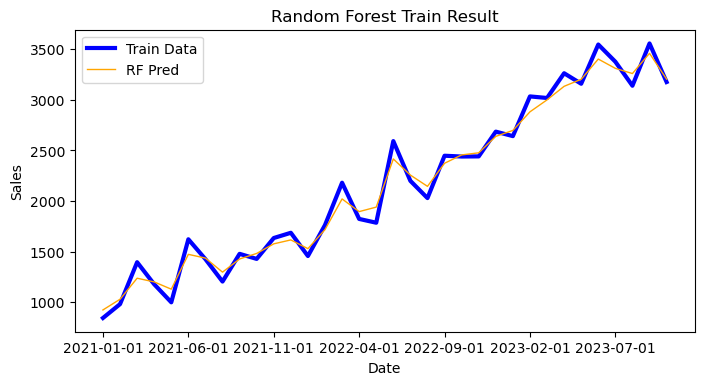

In [80]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
pred_y = forest.predict(X_train)
forest_data = train_data.copy()
forest_data['RF Pred'] = pred_y
plt.figure(figsize=(8, 4), dpi=100)
forest_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=3)
forest_data['RF Pred'].plot(color='orange', label='RF Pred', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Random Forest Train Result')
plt.legend()

### Model Test

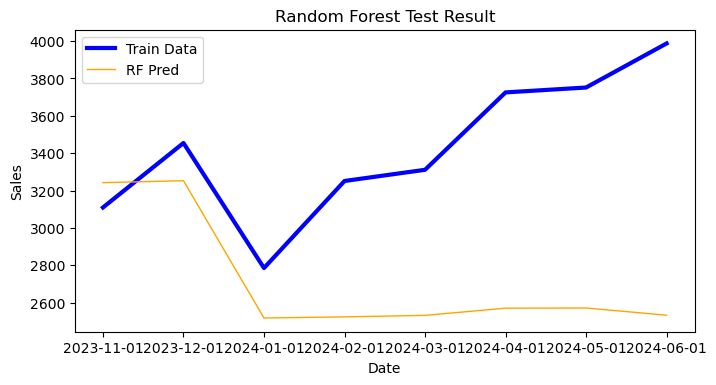

In [81]:
pred_y_test = forest.predict(X_test)
forest_data_test = test_data.copy()
forest_data_test['RF Pred'] = pred_y_test
plt.figure(figsize=(8, 4), dpi=100)
forest_data_test['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=3)
forest_data_test['RF Pred'].plot(color='orange', label='RF Pred', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Random Forest Test Result')
plt.legend()

## XGBoost

### Data Preparation

In [82]:
columns = list(train_data.columns)
columns.remove('Monthly EV Sales with Noise')
xgb_data_train = train_data.copy()
xgb_data_test = test_data.copy()
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(xgb_data_train[columns]), columns=columns)
y_train = train_data['Monthly EV Sales with Noise']
X_test = pd.DataFrame(scaler.transform(xgb_data_test[columns]), columns=columns)
y_test = test_data['Monthly EV Sales with Noise']

### Model Train

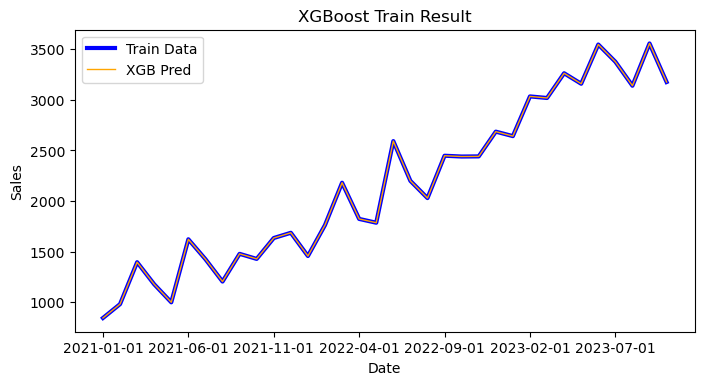

In [83]:
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)
pred_y = xgboost.predict(X_train)
xgb_data = train_data.copy()
xgb_data['XGB Pred'] = pred_y
plt.figure(figsize=(8, 4), dpi=100)
xgb_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=3)
xgb_data['XGB Pred'].plot(color='orange', label='XGB Pred', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('XGBoost Train Result')
plt.legend()

### Model Test

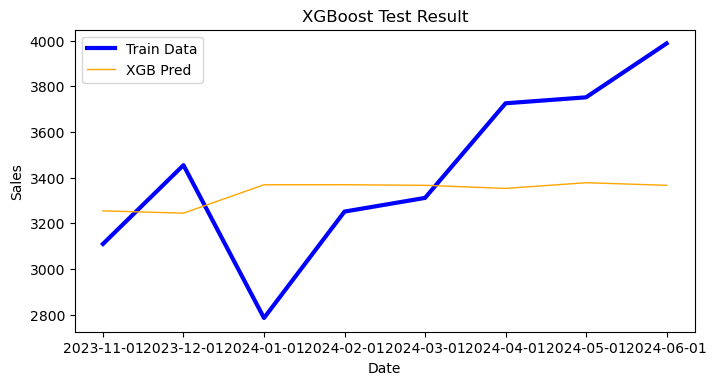

In [84]:
pred_y_test = xgboost.predict(X_test)
xgb_data_test = test_data.copy()
xgb_data_test['XGB Pred'] = pred_y_test
plt.figure(figsize=(8, 4), dpi=100)
xgb_data_test['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=3)
xgb_data_test['XGB Pred'].plot(color='orange', label='XGB Pred', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('XGBoost Test Result')
plt.legend()

From the result, we can see that the result of traditional machine learning models are not satisfactory, which presents serious overfitting.

# Regression with ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[6]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,1,0)[6]             : AIC=409.871, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[6]             : AIC=384.307, Time=0.15 sec
 ARIMA(0,2,1)(0,1,1)[6]             : AIC=inf, Time=0.22 sec
 ARIMA(1,2,0)(0,1,0)[6]             : AIC=406.774, Time=0.04 sec
 ARIMA(1,2,0)(2,1,0)[6]             : AIC=380.255, Time=0.27 sec
 ARIMA(1,2,0)(2,1,1)[6]             : AIC=inf, Time=0.48 sec
 ARIMA(1,2,0)(1,1,1)[6]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(2,1,0)[6]             : AIC=388.881, Time=0.13 sec
 ARIMA(2,2,0)(2,1,0)[6]             : AIC=369.063, Time=0.34 sec
 ARIMA(2,2,0)(1,1,0)[6]             : AIC=373.752, Time=0.15 sec
 ARIMA(2,2,0)(2,1,1)[6]             : AIC=inf, Time=0.64 sec
 ARIMA(2,2,0)(1,1,1)[6]             : AIC=inf, Time=0.44 sec
 ARIMA(3,2,0)(2,1,0)[6]             : AIC=359.029, Time=0.46 sec
 ARIMA(3,2,0)(1,1,0)[6]             : AIC=361.937, Time=0.42 sec
 ARIMA

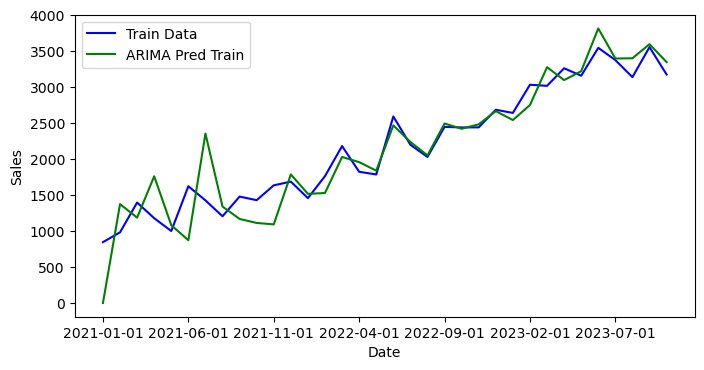

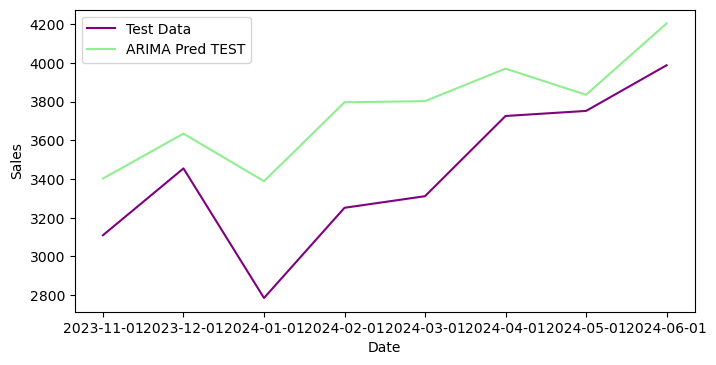

In [85]:
arima_model = pm.auto_arima(train_data['Monthly EV Sales with Noise'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         start_P=0, seasonal=True,
                         d=2, m=6, D=1,
                         trace=True,
                         ic='aic',
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

plt.figure(figsize=(8, 4), dpi=100)
pred_data = pd.DataFrame(arima_model.fittedvalues(), columns=['ARIMA Pred'])
pred_data_test = pd.DataFrame(arima_model.predict((datetime.strptime(test_period[0][1], '%Y-%m-%d') - datetime.strptime(test_period[0][0], '%Y-%m-%d')).days // 30 + 1), columns=['ARIMA Pred'])
train_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue')
pred_data['ARIMA Pred'].plot(color='green', label='ARIMA Pred Train')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
y_pred, y_true = list(train_data['Monthly EV Sales with Noise']), list(pred_data['ARIMA Pred'])
evaluate([y_pred, y_true])
pred_data_test.index = pd.Index([str(index)[:10] for index in pred_data_test.index])

plt.figure(figsize=(8, 4), dpi=100)
test_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='purple')
pred_data_test['ARIMA Pred'].plot(color='lightgreen', label='ARIMA Pred TEST')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Combination

## Residual

In [99]:
shrinkage = 0.01
res_data = sub_data[columns]
res_data['Residual'] = (train_data['Monthly EV Sales with Noise'] - pred_data['ARIMA Pred']) * shrinkage
res_data_train = res_data.loc[train_index]
res_data_test = res_data.loc[test_index]
X_train, y_train = res_data_train[columns], res_data_train['Residual']
X_test, y_test = res_data_test[columns], test_data['Monthly EV Sales with Noise'] - pred_data_test['ARIMA Pred']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns)

## Random Forest

In [116]:
def forest(X_train, y_train, pred_data, shrinkage):
    forest = RandomForestRegressor(n_estimators=30, criterion='absolute_error', max_depth=5)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_train)
    forest_data = train_data.copy()
    forest_data['Pred Residual'] = y_pred
    forest_data['RF Pred'] = forest_data['Pred Residual'] / shrinkage + pred_data['ARIMA Pred']
    plt.figure(figsize=(8, 4), dpi=100)
    forest_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=4)
    pred_data['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    forest_data['RF Pred'].plot(color='lightgreen', label='RF Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return forest, forest_data['RF Pred']

def forest_test(forest, X_test, pred_data_test, shrinkage):
    y_pred = forest.predict(X_test)
    forest_data = test_data.copy()
    forest_data['Pred Residual'] = y_pred
    forest_data['RF Pred'] = forest_data['Pred Residual'] / shrinkage + pred_data_test['ARIMA Pred']
    plt.figure(figsize=(8, 4), dpi=100)
    forest_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='blue', linewidth=4)
    pred_data_test['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    forest_data['RF Pred'].plot(color='lightgreen', label='RF Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return forest_data['RF Pred']

## XGBoost

In [120]:
def xgb(X_train, y_train, pred_data, shrinkage):
    xgb = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, alpha=1, reg_lambda=2)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_train)
    xgb_data = train_data.copy()
    xgb_data['Pred Residual'] = y_pred
    xgb_data['XGB Pred'] = xgb_data['Pred Residual'] / shrinkage + pred_data['ARIMA Pred']
    plt.figure(figsize=(8, 4), dpi=100)
    xgb_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=4)
    pred_data['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    xgb_data['XGB Pred'].plot(color='lightgreen', label='XGB Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return xgb, xgb_data['XGB Pred']

def xgb_test(xgb, X_test, pred_data_test, shrinkage):
    y_pred = xgb.predict(X_test)
    xgb_data = test_data.copy()
    xgb_data['Pred Residual'] = y_pred
    xgb_data['XGB Pred'] = xgb_data['Pred Residual'] / shrinkage + pred_data_test['ARIMA Pred']
    plt.figure(figsize=(8, 4), dpi=100)
    xgb_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='blue', linewidth=4)
    pred_data_test['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    xgb_data['XGB Pred'].plot(color='lightgreen', label='XGB Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return xgb_data['XGB Pred']

## Train & Test

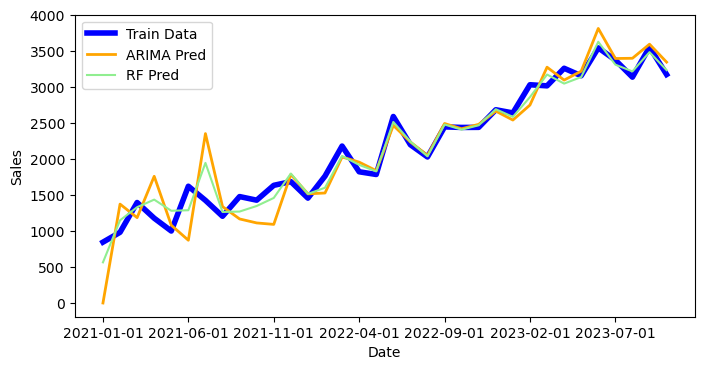

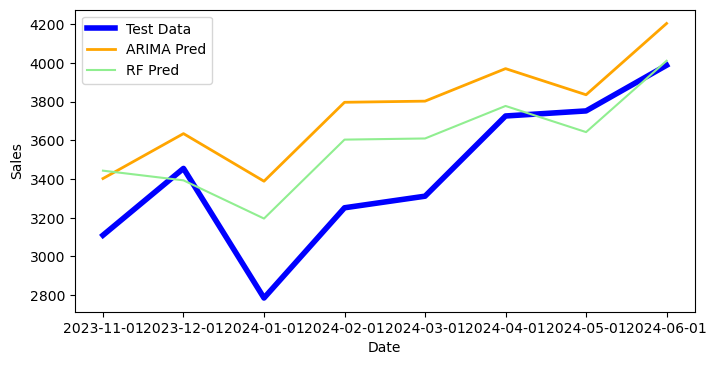

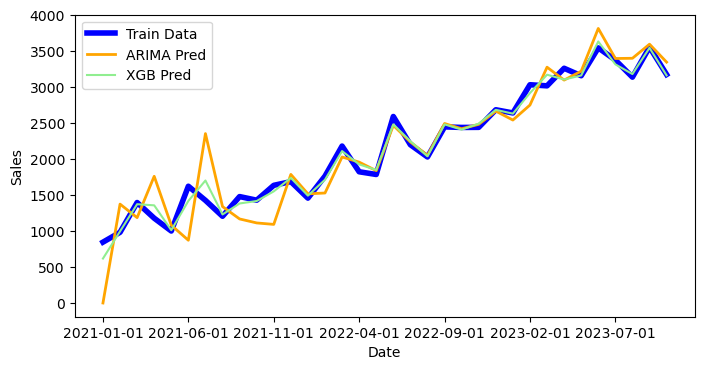

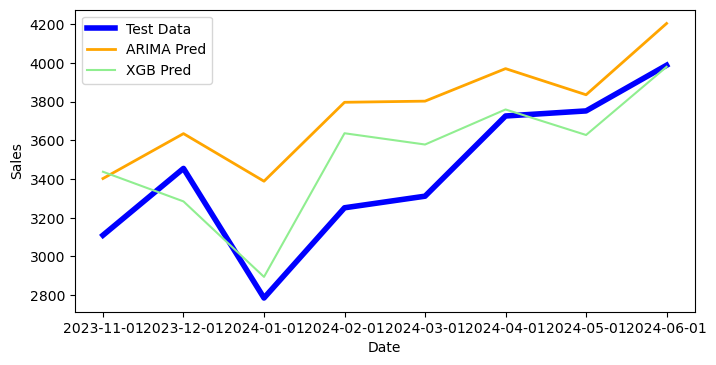

In [121]:
res_forest = forest(X_train, y_train, pred_data, shrinkage)
res_forest_test = forest_test(res_forest[0], X_test, pred_data_test, shrinkage)

res_xgb = xgb(X_train, y_train, pred_data, shrinkage)
res_xgb_test = xgb_test(res_xgb[0], X_test, pred_data_test, shrinkage)

## Metrics Comparation

In [136]:
arima_train = evaluate([pred_data['ARIMA Pred'].iloc[1:], train_data['Monthly EV Sales with Noise'].iloc[1:]])
arima_test = evaluate([pred_data_test['ARIMA Pred'], test_data['Monthly EV Sales with Noise']])
forest_train = evaluate([res_forest[1], train_data['Monthly EV Sales with Noise']])
forest_test = evaluate([res_forest_test, test_data['Monthly EV Sales with Noise']])
xgb_train = evaluate([res_xgb[1], train_data['Monthly EV Sales with Noise']])
xgb_test = evaluate([res_xgb_test, test_data['Monthly EV Sales with Noise']])
metrics_df = None
metrics_df = pd.concat([metrics_df, pd.DataFrame(arima_train, index=pd.Index(['Arima Train']))])
metrics_df = pd.concat([metrics_df, pd.DataFrame(arima_test, index=pd.Index(['Arima Test']))])
metrics_df = pd.concat([metrics_df, pd.DataFrame(forest_train, index=pd.Index(['Forest Train']))])
metrics_df = pd.concat([metrics_df, pd.DataFrame(forest_test, index=pd.Index(['Forest Test']))])
metrics_df = pd.concat([metrics_df, pd.DataFrame(xgb_train, index=pd.Index(['XGB Train']))])
metrics_df = pd.concat([metrics_df, pd.DataFrame(xgb_test, index=pd.Index(['XGB Test']))])
metrics_df

,RMSE,MAE,MAPE
Arima Train,300.134113,209.879567,0.131209
Arima Test,376.347784,331.924870,0.090108
Forest Train,165.820232,124.717549,0.081066
Forest Test,252.823107,204.981259,0.059150
XGB Train,99.947857,72.374575,0.044895
XGB Test,219.231216,178.150661,0.051330


# RNN

In [161]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = data
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.targets[index + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor([y])

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

dataset_train = TimeSeriesDataset(X_train.values, y_train.values, 1)
dataset_test = TimeSeriesDataset(X_test.values, y_test.values, 1)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)
model = RNN(len(X_train.columns), hidden_size=32, output_size=1)

In [167]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
criterion = nn.MSELoss()
nums_epochs = 100
for epoch in range(nums_epochs):
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{nums_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0269
Epoch [20/100], Loss: 0.0339
Epoch [30/100], Loss: 0.0398
Epoch [40/100], Loss: 0.0445
Epoch [50/100], Loss: 0.0450
Epoch [60/100], Loss: 0.0431
Epoch [70/100], Loss: 0.0375
Epoch [80/100], Loss: 0.0302
Epoch [90/100], Loss: 0.0218
Epoch [100/100], Loss: 0.0138


[-1.6462188959121704, -1.21299147605896, -2.7155277729034424, -3.320213794708252, 0.25504863262176514, -2.1222872734069824, 0.29481780529022217, 3.6627211570739746, 3.4428458213806152, 2.152894973754883, 0.1671990156173706, 0.8807622194290161, 1.0812898874282837, 0.854729175567627, -0.7965937852859497, -0.7232216596603394, 0.6260312795639038, -0.14930331707000732, -0.3947063684463501, -0.872998833656311, -0.20948505401611328, 0.22544372081756592, 0.8771489262580872, 1.7922461032867432, 1.4837071895599365, -1.3477768898010254, 0.14850640296936035, -0.2579580545425415, -1.5732873678207397, -1.4812613725662231, -2.2066619396209717, -0.6704131364822388, -1.6035608053207397]
[-2.0003762245178223, -2.2052855491638184, -0.45998871326446533, -0.45986807346343994, -0.45969927310943604, -0.4595133066177368, -0.4594937562942505]


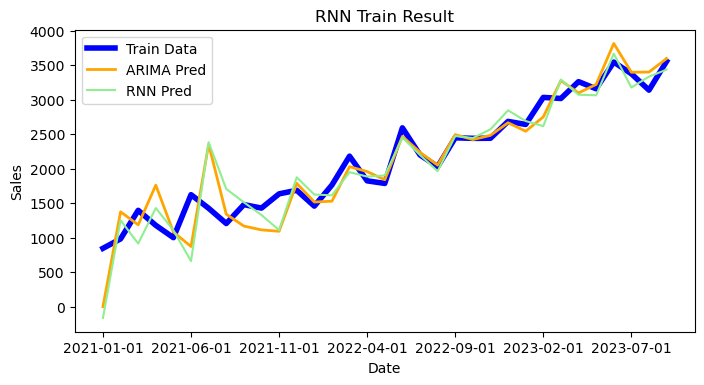

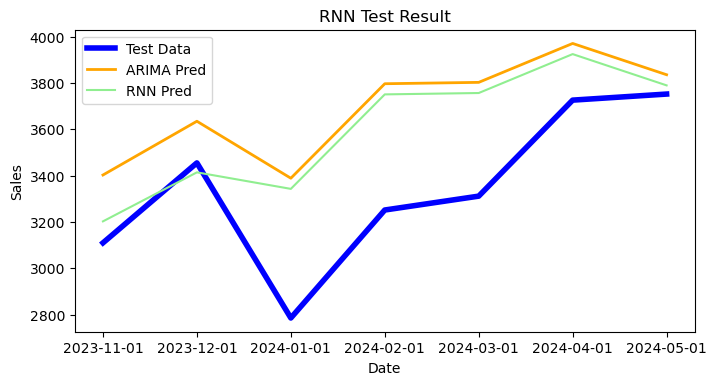

In [168]:
predictions = []
with torch.no_grad():
    for x_batch, _ in train_loader:
        output = model(x_batch)
        predictions.append(output.numpy())

predictions = np.array(predictions).reshape(-1).tolist()
print(predictions)
plt.figure(figsize=(8, 4), dpi=100)
train_data['Monthly EV Sales with Noise'].iloc[:-1].plot(label='Train Data', color='blue', linewidth=4)
pred_data['ARIMA Pred'].iloc[:-1].plot(color='orange', label='ARIMA Pred', linewidth=2)
train_data['RNN Pred'] = [prediction / shrinkage for prediction in predictions] + pred_data['ARIMA Pred'].iloc[:-1]
train_data['RNN Pred'].plot(color='lightgreen', label='RNN Pred')
plt.title('RNN Train Result')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

predictions = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        output = model(x_batch)
        predictions.append(output.numpy())

predictions = np.array(predictions).reshape(-1).tolist()
print(predictions)
plt.figure(figsize=(8, 4), dpi=100)
test_data['Monthly EV Sales with Noise'].iloc[:-1].plot(label='Test Data', color='blue', linewidth=4)
pred_data_test['ARIMA Pred'].iloc[:-1].plot(color='orange', label='ARIMA Pred', linewidth=2)
test_data['RNN Pred'] = [prediction / shrinkage for prediction in predictions] + pred_data_test['ARIMA Pred'].iloc[:-1]
test_data['RNN Pred'].plot(color='lightgreen', label='RNN Pred')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('RNN Test Result')
plt.legend()